# Collect synthesis condition

In [8]:
from llm_miner import JournalReader
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from collections import Counter

In [9]:
JR_path = '../11_final_output_re_re'
files = list(Path(JR_path).glob('*/*.json'))

In [10]:
def get_syn_condition(file, total_data):
    try:
        jr = JournalReader.from_json(file)
    except Exception:
        return
    
    try:
        year = int(jr.metadata.date.split('.')[0])
    except:
        year = None

    for result in jr.result:
        if 'processes' not in result:
            continue

        data = {'year': year}
        process = result['processes']
        data['processes'] = process
        
        data['meta'] = result.material.to_dict()
        data['doi'] = jr.doi

        if not process:
            continue

        synthesis = False
        precursors = []
        solvents = []
        for operation in process:
            if operation['synthesis method'] in ['chemical synthesis', 'solvothermal synthesis', 'sonochemical synthesis', 'hydrothermal synthesis']:
                if 'precursor' not in operation:
                    continue

                for pre in operation['precursor']:
                    precursors.append(pre['name'])
                
                synthesis = True
            else:
                continue
        
        if synthesis:
            data['precursor'] = precursors
            total_data.append(data)
        else:
            continue


    return total_data

In [16]:
total_data = []
for file in files:
    get_syn_condition(file, total_data=total_data)

In [18]:
has_refcode_data = [
    i for i in total_data if isinstance(i['meta']['refcode'], str)
]

# Precursor list

In [66]:
counter = Counter()
for data in has_refcode_data:
    precursor = data['precursor']
    counter.update(precursor)

In [73]:
df = pd.DataFrame(counter.most_common())
df.to_csv('precursor.csv', encoding='utf-8-sig')

# Load precursor_list

In [19]:
from matplotlib import pyplot as plt
import numpy as np

In [20]:
df = pd.read_excel('assets/precursor.xlsx')

In [21]:
df_solvent = pd.read_excel('assets/solvent.xlsx').replace({np.nan: None})

In [22]:
name_dict = {i['Name']: i['Check (M/N/X/O)'] for i in df.iloc()}
solvent_dict = {i["name"]: i["standard_name"] for i in df_solvent.iloc()}

In [23]:
operations = ['ball milling', 'centrifugation', 'chemical mechanical polishing', 'chemical synthesis', 'chemical vapor deposition', 'drying', 'electrochemical deposition', 'heat treatment', 'microwave-assisted synthesis', 'mixing', 'rinsing', 'solvothermal synthesis', 'sol-gel synthesis', 'sonication', 'sonochemical synthesis', 'thermal evaporation', 'wet etching', 'washing', 'cooling', 'pH adjustment', 'filtration']

In [24]:
sorted_output = []
for data in has_refcode_data:
    is_target = True
    for pre in data['precursor']:
        tag = name_dict.get(pre, 'X')
        if tag not in ['M', 'N']:
            is_target = False

    for process in data['processes']:
        name = process['synthesis method']
        if name not in operations:
            is_target = False

    
    if is_target:
        sorted_output.append(data)

print (len(sorted_output))

9197


In [25]:
sorted_output[0]

{'year': 2019,
 'processes': [{'synthesis method': 'solvothermal synthesis',
   'precursor': [{'name': 'Zn(NO3)2⋅6H2O', 'amount': '45', 'unit': 'mg'},
    {'name': 'H4abtc', 'amount': '0.0358', 'unit': 'g'}],
   'solvent': [{'name': 'DMA', 'amount': '5.0', 'unit': 'mL'}],
   'reducing agent': [{'name': '', 'amount': '', 'unit': ''}],
   'surfactant': [{'name': '', 'amount': '', 'unit': ''}],
   'pressure': '',
   'temperature': '120°C',
   'time': '72h',
   'heating rate': '',
   'cooling rate': '48h'},
  {'synthesis method': 'filtration',
   'time': '',
   'atmosphere': '',
   'pressure': ''},
  {'synthesis method': 'washing', 'washing solution': 'DMA', 'amount': ''},
  {'synthesis method': 'drying',
   'pressure': '',
   'temperature': '',
   'atmosphere': '',
   'time': ''}],
 'meta': {'name': '{[Zn2(abtc)(H2O)3](DMA)}n',
  'symbol': '1',
  'chemical_formula': 'C16 H6 N2 O11 Zn2',
  'formula_source': 'csd',
  'synonyms': [],
  'refcode': 'JOPKAD',
  'is_general': True},
 'doi': '10.

In [26]:
year_counter = Counter()
for data in sorted_output:
    if isinstance(data['year'], int):
        year_counter.update([data['year']])

In [27]:
years, counts = zip(*year_counter.most_common())

Text(0.5, 0, 'Year')

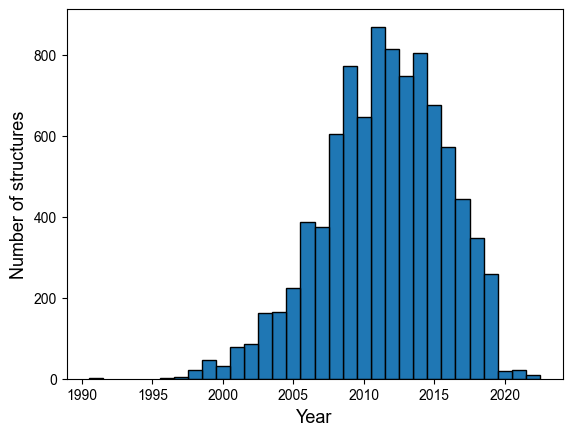

In [29]:
plt.rcParams['font.family'] = 'arial'
plt.bar(years, counts, width=1, linewidth=1, edgecolor='k')
plt.ylabel('Number of structures', fontsize=13)
plt.xlabel('Year', fontsize=13)


# Parse data

In [30]:
from collections import namedtuple
import pprint
from word2number import w2n
import regex

In [31]:
field = ('precursors', 'synthesis_method', 'solvent', 'temperature', 'time', 'pressure', 'cooling', 'pH_adjustment', 'washing', 'filtration', 'drying')
class Recipt(object):
    precursors = None
    # ratio = None
    synthesis_method = None
    solvent = None
    temperature = None
    time = None
    pressure = None
    cooling = False
    pH_adjustment = False
    washing = False
    filtration = False
    drying = False

    def to_dict(self):
        return {key: getattr(self, key) for key in field}


In [32]:
a = iter(range(5000))

In [33]:
time_exception = {
    'half an hour': '30 min',
    '0.5 h': '30 min',
    '0.5-h': '30 min',
    '120-h': '120 hours',
    '1 hour 45 minutes': '105 min',
}

temperature_exception = {
    '36 °C for 2 days, and then at 75 °C for another 3 days': '75 °C',
    'mild heating': '50 °C',
    'boiling': '100 °C',
    'refrigerator temperature': '0 °C',
    'hot': '100 °C',
    '100 C': '100 °C',
    'moderately heated': '50 °C'
}

pressure_exception = {
    'ca. 1.1 MPa': '10 atm',
    '~10-3 Torr': '0 atm',
    'reduced': '0 atm',
    '2.2 atm': '2.2 atm',
    '3 bar': '3 atm',
    '30psi': '2 atm'

}

In [34]:
def parse_number(number):
    number = regex.sub(r"(^|\s)(ca\.|~|about|±\s?(\d|\.)+)(\s|\d|$)", "", number).strip()

    try:
        number = int(number)
    except Exception:
        pass
    else:
        return number
    
    try:
        number = float(number)
    except Exception:
        pass
    else:
        return number
    
    try:
        number = w2n.word_to_num(number)
    except Exception:
        pass
    else:
        return number
    
    if number in ['half-an-', 'half']:
        return 0.5
    
    try:
        if "-" in number:
            split = '-'
        elif 'to' in number:
            split = 'to'
        elif 'or' in number:
            split = 'or'
        
        a, b = number.split(split)
        number = (int(a) + int(b)) / 2
    except Exception:
        pass
    else:
        return number


    # print (number)
    raise ValueError()

In [35]:
def parse_temperature(temperature: str, syn_method: str):
    temperature = regex.sub(r"(approx\.|approximately|~)", "", temperature).strip()
    temperature = temperature_exception.get(temperature, temperature)

    if "°C" in temperature:
        temperature = temperature.replace("°C", "").strip()
        temperature = parse_number(temperature)
        temperature = f"{temperature} °C"
    elif '℃' in temperature:
        temperature = temperature.replace("°C", "").strip()
        temperature = parse_number(temperature)
        temperature = f"{temperature} °C"
    elif "°F" in temperature:
        raise ValueError()
    elif "°" in temperature:
        temperature = temperature.replace("°", "").strip()
        temperature = parse_number(temperature)
        temperature = f"{temperature} °C"
    elif "K" in temperature:
        temperature = parse_number(temperature.replace("K", "").strip())
        temperature = f"{temperature - 273} °C"
    elif temperature in ['room temperature', 'air atmosphere', 'ambient temperature', 'reflux', 'refluxed', 'ambient', 'ambient conditions']:
        temperature = '25 °C'
    elif not temperature:
        if syn_method in ['solvothermal synthesis', 'hydrothermal synthesis']:
            temperature = None
        else:
            temperature = '25 °C'
    else:
        print ('temperature:', temperature)
        temperature = None

    return temperature

def parse_pressure(pressure: str, syn_method: str):
    pressure = pressure.strip()

    if pressure in ['autogenous', 'autogeous',  'auto-generated', 'autogenerated', 'self-generated', 'autogenious', 'autogenously atmospheric pressure', 'autogeneous', 'sealed', 'autogenously applied', 'autogenously', 'autogenous pressure', 'auto-genous']:
        pressure = 'autogenous'
    elif pressure in ['room pressure', 'air', 'air atmosphere', 'ambient']:
        pressure = '1 atm'
    elif pressure in ['almost vacuum', 'vacuume', 'near-vacuum', 'vacuum', ]:
        pressure = '0 atm'
    elif not pressure:
        if syn_method in ['solvothermal synthesis', 'hydrothermal synthesis']:
            pressure = 'autogenous'
        else:
            pressure = '1 atm'
    elif pressure in pressure_exception:
        pressure = pressure_exception['pressure']
    else:
        print ('pressure: ', pressure)
        pressure = None

    return pressure

def parse_time(time: str):
    time = time_exception.get(time, time)
    
    unit = regex.search(r"(?<=\b|\d)(days|day|weeks|week|hours|hour|h|minute|min|s)\b", time)
    if not unit:
        return None
    unit = unit.group()
    time = time.replace(unit, "").strip()
    if time == 'several':
        time = '4'
    elif time == 'a few':
        time = '2'
    elif time == 'a couple of':
        time = '2'
    elif time == 'an':
        time = '1'

    time = parse_number(time)
    time = f'{time} {unit}'

    return time

def parse_cooling(cooling, syn_method):
    if cooling:
        return True
    elif syn_method in ['solvothermal synthesis', 'hydrothermal synthesis']:
        return True
    else:
        return False

def parse_solvent(operation):
    if 'solution' in operation:
        solvents = operation['solution']
    elif 'solvent' in operation:
        solvents = operation['solvent']
    else:
        return None

    sol_ls = []
    for sol in solvents:
        sol = regex.split(r"\band\b|\,|\/", sol['name'])
        for i in sol:
            i = i.strip()
            i = solvent_dict.get(i, None)
            if not i:
                continue
            elif ',' in i:
                sol_ls.extend(i.split(','))
            else:
                sol_ls.append(i)

    sol_ls = list(set(sol_ls))


    return sol_ls

def parse_washing(washing_solution):
    if not washing_solution:
        return False
    sol = regex.split(r"\band\b|\,|\/", washing_solution)
    sol_ls = []
    for i in sol:
        i = i.strip()
        i = solvent_dict.get(i, None)
        if not i:
            continue
        elif ',' in i:
            sol_ls.extend(i.split(','))
        else:
            sol_ls.append(i)
    sol_ls = list(set(sol_ls))
    return sol_ls


def parse_dataset(process):
    data = Recipt()

    for operation in process:
        syn_method = operation['synthesis method']
        if syn_method in ['chemical synthesis', 'solvothermal synthesis', 'sonochemical synthesis', 'hydrothermal synthesis']:
            data.precursors = [i['name'] for i in operation['precursor']]

            data.solvent = parse_solvent(operation)
            data.synthesis_method = syn_method
            data.temperature = parse_temperature(operation['temperature'], syn_method)
            data.pressure = parse_pressure(operation['pressure'], syn_method)
            data.time = parse_time(operation['time'])
            data.cooling = parse_cooling(operation.get('cooling rate'), syn_method)

            pass
        elif syn_method == 'filtration':
            data.filtration = True
        elif syn_method == 'washing':
            data.washing = parse_washing(operation['washing solution'])
        elif syn_method == 'pH adjustment':
            data.pH_adjustment = operation['pH']
        elif syn_method == 'drying':
            data.drying = True
    
    return data


In [37]:
# Test
i = 8416
process = sorted_output[i]['processes']
pprint.pprint(process, sort_dicts=False)
print ('------------------------------')
pprint.pprint(parse_dataset(process).to_dict(), sort_dicts=False)

[{'synthesis method': 'solvothermal synthesis',
  'precursor': [{'name': 'H2MDP', 'amount': '0.020', 'unit': 'g'},
                {'name': 'ZnNO3⋅6H2O', 'amount': '0.297', 'unit': 'g'}],
  'solvent': [{'name': 'distilled water', 'amount': '10', 'unit': 'mL'}],
  'pressure': '',
  'temperature': '180°C',
  'time': '18 h',
  'heating rate': '',
  'cooling rate': 'slowly to 25°C'}]
------------------------------
{'precursors': ['H2MDP', 'ZnNO3⋅6H2O'],
 'synthesis_method': 'solvothermal synthesis',
 'solvent': ['water'],
 'temperature': '180 °C',
 'time': '18 h',
 'pressure': 'autogenous',
 'cooling': True,
 'pH_adjustment': False,
 'washing': False,
 'filtration': False,
 'drying': False}


# Make Prompt

In [47]:
import json
from sklearn.model_selection import train_test_split

In [48]:
PROMPT = """You act like a MOF synthesis expert. I will give you precursors of MOF and you have to suggest the appropriate synthesis conditions for this MOF. You have to suggest the synthesis conditions in JSON format and contain these categories : ['precursor', 'synthesis_method', 'solvent', 'temperature', 'time', 'pressure', 'cooling', 'pH_adjustment', 'washing', 'filtration', 'drying']."""
pprint.pprint(PROMPT)

('You act like a MOF synthesis expert. I will give you precursors of MOF and '
 'you have to suggest the appropriate synthesis conditions for this MOF. You '
 'have to suggest the synthesis conditions in JSON format and contain these '
 "categories : ['precursor', 'synthesis_method', 'solvent', 'temperature', "
 "'time', 'pressure', 'cooling', 'pH_adjustment', 'washing', 'filtration', "
 "'drying'].")


In [28]:
jsonl = []
year = []
# solvent_count = Counter()
for i, data in tqdm(enumerate(sorted_output), total=len(sorted_output)):
    process = data['processes']
    try:
        process = parse_dataset(process)
        # solvent_count.update(process.solvent)
    except Exception:
        continue

    json_file = {
        "messages": [
            {"role": "system", "content": PROMPT},
            {"role": "user", "content": json.dumps(data['precursor'])},
            {"role": "assistant", "content": json.dumps(process.to_dict())},
        ]
    }
    jsonl.append(json_file)
    year.append(data['year'])

100%|██████████| 9197/9197 [00:00<00:00, 38769.64it/s]


In [56]:
for i in range(5):
    train, test = train_test_split(jsonl, random_state=i)

    with open(f'train_{i}.jsonl', 'w') as f:
        for db in train:
            if "\", \"" in db['messages'][1]['content']:
                f.write(json.dumps(db) + "\n")

    with open(f'test_{i}.jsonl', 'w') as f:
        for db in test:
            if "\", \"" in db['messages'][1]['content']:
                f.write(json.dumps(db) + "\n")

# Year dataset

In [31]:
len(train), len(test)

(6783, 2261)

In [32]:
n_count = [0, 0]
year_list = [1998, 2001, 2004, 2007, 2010, 2013, 2016]
for d, y in zip(jsonl, year):
    if not y:
        continue

    for y2 in year_list:
        if y <= y2:
            with open(f'year_test/year_{y2}.jsonl', 'a') as f:
                f.write(json.dumps(d) + "\n")
    # if y > 2016:
    with open(f'year_test/year_test_{y}.jsonl', 'a') as f:
        f.write(json.dumps(d) + "\n")
    